In [4]:
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm import trange
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.utils import shuffle

In [15]:
class CNN1D(nn.Module):
    def __init__(self, number_of_categories):
        super(CNN1D, self).__init__()
        # convolution layer
        # in_channels must be the same as the number of subcarriers, out_channels can be any value
        self.conv1d = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.conv1d_2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding='same')
        self.conv1d_3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same')
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(64)
        self.batch_norm_2 = nn.BatchNorm1d(128)
        self.batch_norm_3 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout1d(p=0.5)
        

        # calculate the in_features
        self.fc1 = nn.Linear(in_features=1280, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=number_of_categories)

    def forward(self, x):
        # input tensor size [batch_size, 64 (features), 40 (sequence length)]
        x = self.conv1d(x)
        # # [batch_size, 64 (features), 40 (sequence length)]
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool(x)
        
        x = self.conv1d_2(x)
        # # [batch_size, 64 (features), 40 (sequence length)]
        x = self.batch_norm_2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool(x)
        
        x = self.conv1d_3(x)
        # # [batch_size, 64 (features), 40 (sequence length)]
        x = self.batch_norm_3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool(x)
        
        x = x.view(-1, x.shape[1] * x.shape[2])  # Adjust the input size based on the output size after convolutions and pooling\
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [6]:
class CSIDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.int)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [7]:
def importData():
    X_train, X_val, X_test, y_train, y_val, y_test = [], [], [], [], [], []
    for i in range(10):
        temp_train = np.load(f'../data/process_data/{i}_table_train.npy')
        temp_val = np.load(f'../data/process_data/{i}_table_val.npy')
        temp_test = np.load(f'../data/process_data/{i}_table_test.npy')
        if i == 0:
            X_train = temp_train
            X_val = temp_val
            X_test = temp_test
            y_train = np.array([[i] for _ in range(X_train.shape[0])])
            y_val = np.array([[i] for _ in range(X_val.shape[0])])
            y_test = np.array([[i] for _ in range(X_test.shape[0])])
        else:
            X_train = np.append(X_train, temp_train, axis=0)
            X_val = np.append(X_val, temp_val, axis=0)
            X_test = np.append(X_test, temp_test, axis=0)
            y_train = np.append(y_train, np.array([[i] for _ in range(temp_train.shape[0])]), axis=0)
            y_val = np.append(y_val, np.array([[i] for _ in range(temp_val.shape[0])]), axis=0)
            y_test = np.append(y_test, np.array([[i] for _ in range(temp_test.shape[0])]), axis=0)
            
    return X_train, X_val, X_test, y_train, y_val, y_test

In [8]:
class RunningAverage:
    def __init__(self):
        self.steps = 0
        self.total = 0

    def update(self, val):
        self.total += val
        self.steps += 1

    def __call__(self):
        return self.total / float(self.steps)

def accuracy(outputs, labels):
    # outputs (predicted), labels (true)
    outputs = np.argmax(outputs.cpu().detach().numpy(), axis=1)
    labels = labels.squeeze()
    # compare outputs with labels
    return np.sum([1 if first == second else 0 for first, second in zip(labels, outputs)]) / float(len(labels))

In [9]:
def train(model, optimizer, trainLoader, loss_fn, iterations):
    model.train()
    train_loss = RunningAverage()
    train_acc = RunningAverage()
    
    with trange(iterations) as pbar:
        for X_batch, y_batch in trainLoader:
            y_batch = y_batch.type(torch.LongTensor).squeeze(1)
            logits = model(X_batch)
            y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
            loss = loss_fn(logits, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss.update(loss)
            train_acc.update(accuracy(y_pred, y_batch))
            pbar.update(1)
            
    return train_loss(), train_acc()
    
def eval(model, valLoader, loss_fn):
    model.eval()
    eval_loss = RunningAverage()
    eval_acc = RunningAverage()
    
    with torch.no_grad():
        for X_batch, y_batch in valLoader:
            y_batch = y_batch.type(torch.LongTensor).squeeze(1)
            logits = model(X_batch)
            y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
            loss = loss_fn(logits, y_batch)
            
            eval_loss.update(loss)
            eval_acc.update(accuracy(y_pred, y_batch))
            
    return eval_loss(), eval_acc()
    
def test(model, testLoader, test_size):
    model.eval()
    for X_batch, y_batch in testLoader:
        y_batch = y_batch.type(torch.LongTensor).squeeze(1)
        logits = model(X_batch)
        y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
        
    print(f"Overall Accuracy: {accuracy(y_pred, y_batch):.3f}")

    # True positive percentage
    percentages = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
    # outputs (predicted), labels (true)
    outputs = np.argmax(y_pred.cpu().detach().numpy(), axis=1)
    labels = y_batch.squeeze()
    
    for i in range(len(outputs)):
        if outputs[i] == labels[i]:
            percentages[outputs[i]] += 1
    
    # plot the percentages of correct predictions
    y_percent = [(value/(test_size/10))*100 for key, value in percentages.items()]
    x_label = [str(key) for key, _ in percentages.items()]
    
    fig, test = plt.subplots(figsize=(10,6))
    test.bar(x_label, y_percent)
    test.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Key")
    plt.title("Accuracy (%) per key")
    plt.savefig("percentage_correct_final.png", bbox_inches='tight')
    plt.show()
    
    cm = confusion_matrix(y_true=labels, y_pred=outputs)
    cm = np.divide(cm, (test_size/10))
    
    plt.figure(figsize=(10,6))
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.savefig("confusion_matrix_final.png", bbox_inches='tight')
    plt.show()
    
    print(f"Accuracy for each key: {''.join([x + ': ' + str(round(y, 3)) + '% ' for x, y in zip(x_label, y_percent)])}")
    
    print(classification_report(y_true=labels, y_pred=outputs, target_names=x_label))

In [10]:
def train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss_fn, iterations):
    # for plotting the loss and accuracy
    train_loss_list, train_acc_list, eval_loss_list, eval_acc_list  = [], [], [], []
        
    for epoch in range(epochs):
        train_loss, train_acc = train(model, optimizer, trainLoader, loss_fn, iterations)
        eval_loss, eval_acc = eval(model, valLoader, loss_fn)
        
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        eval_loss_list.append(eval_loss)
        eval_acc_list.append(eval_acc)
        
        print(f"Train: Epoch {epoch}: Loss {train_loss}, Accuracy {train_acc}")
        print(f"Eval: Epoch {epoch}: Loss {eval_loss}, Accuracy {eval_acc}")
        
    return train_loss_list, train_acc_list, eval_loss_list, eval_acc_list
        

In [11]:
def plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs):
    x = [i for i in range(1, epochs+1)]
    
    fig, loss = plt.subplots(figsize=(10,6))
    loss.plot(x, [trainLoss.item() for trainLoss in train_loss_list], label="Training Loss")
    loss.plot(x, [evalLoss.item() for evalLoss in eval_loss_list], label="Validation Loss")
    plt.legend()
    plt.ylabel("Average Loss")
    plt.xlabel("Epochs")
    plt.title("Average Loss per epoch")
    plt.savefig("loss_per_epoch_final.png", bbox_inches='tight')
    
    plt.show()
    
    fig, acc = plt.subplots(figsize=(10,6))
    acc.plot(x, [trainAcc.item() for trainAcc in train_acc_list], label="Training Accuracy")
    acc.plot(x, [evalAcc.item() for evalAcc in eval_acc_list], label="Validation Accuracy")
    plt.legend()
    plt.ylabel("Average Accuracy")
    plt.xlabel("Epochs")
    plt.title("Average Accuracy per epoch")
    plt.savefig("acc_per_epoch_final.png", bbox_inches='tight')
    plt.show()

In [12]:
def print_model_parameters(model):
    total_parameters = 0
    print(" "*20 + "Model Parameters" + " "*20)
    print("="*57)
    print(f"{'Layer':<25}" + "| Parameters")
    print("="*57)
    for name, param in model.named_parameters():
        temp = 1
        temp_list = []
        if param.requires_grad:
            print(f"{name:<25}", end="")
            for i in param.data.shape:
                temp *= i
                temp_list.append(str(i))
            print(": ", end="")
            if len(temp_list) > 1:
                print(f"{' * '.join(temp_list)}", end="")
                print(" = " + str(temp))
            else:
                print(f"{''.join(temp_list)}")

        total_parameters += temp
        
    print("="*57)
    print(f"{'Total parameters':<25}" + f": {total_parameters}")
    print("="*57)

100%|██████████| 55/55 [00:01<00:00, 37.24it/s]


Train: Epoch 0: Loss 2.327958822250366, Accuracy 0.09444731404958677
Eval: Epoch 0: Loss 2.3030037879943848, Accuracy 0.106640625


100%|██████████| 55/55 [00:01<00:00, 35.26it/s]


Train: Epoch 1: Loss 2.3165080547332764, Accuracy 0.10263429752066115
Eval: Epoch 1: Loss 2.3029932975769043, Accuracy 0.1021484375


100%|██████████| 55/55 [00:01<00:00, 31.21it/s]


Train: Epoch 2: Loss 2.315826416015625, Accuracy 0.10278925619834711
Eval: Epoch 2: Loss 2.3023600578308105, Accuracy 0.1


100%|██████████| 55/55 [00:01<00:00, 42.77it/s]


Train: Epoch 3: Loss 2.3106331825256348, Accuracy 0.09656508264462811
Eval: Epoch 3: Loss 2.3024675846099854, Accuracy 0.096875


100%|██████████| 55/55 [00:01<00:00, 42.37it/s]


Train: Epoch 4: Loss 2.3088340759277344, Accuracy 0.10813533057851239
Eval: Epoch 4: Loss 2.3024730682373047, Accuracy 0.0984375


100%|██████████| 55/55 [00:01<00:00, 41.18it/s]


Train: Epoch 5: Loss 2.304840326309204, Accuracy 0.10764462809917356
Eval: Epoch 5: Loss 2.3042120933532715, Accuracy 0.10546875


100%|██████████| 55/55 [00:01<00:00, 41.04it/s]


Train: Epoch 6: Loss 2.3051369190216064, Accuracy 0.11867252066115704
Eval: Epoch 6: Loss 2.304443359375, Accuracy 0.0978515625


100%|██████████| 55/55 [00:01<00:00, 42.37it/s]


Train: Epoch 7: Loss 2.302846908569336, Accuracy 0.11342975206611569
Eval: Epoch 7: Loss 2.3040828704833984, Accuracy 0.1033203125


100%|██████████| 55/55 [00:01<00:00, 42.47it/s]


Train: Epoch 8: Loss 2.305044174194336, Accuracy 0.10160123966942149
Eval: Epoch 8: Loss 2.3037455081939697, Accuracy 0.11328125


100%|██████████| 55/55 [00:01<00:00, 42.50it/s]


Train: Epoch 9: Loss 2.3006930351257324, Accuracy 0.11464359504132232
Eval: Epoch 9: Loss 2.3039474487304688, Accuracy 0.1


100%|██████████| 55/55 [00:01<00:00, 43.24it/s]


Train: Epoch 10: Loss 2.3021178245544434, Accuracy 0.11061466942148761
Eval: Epoch 10: Loss 2.304124116897583, Accuracy 0.10703125


100%|██████████| 55/55 [00:01<00:00, 43.65it/s]


Train: Epoch 11: Loss 2.302002429962158, Accuracy 0.1121642561983471
Eval: Epoch 11: Loss 2.3049025535583496, Accuracy 0.09921875


100%|██████████| 55/55 [00:01<00:00, 43.04it/s]


Train: Epoch 12: Loss 2.2996087074279785, Accuracy 0.11766528925619835
Eval: Epoch 12: Loss 2.305859327316284, Accuracy 0.091015625


100%|██████████| 55/55 [00:01<00:00, 43.27it/s]


Train: Epoch 13: Loss 2.3021278381347656, Accuracy 0.11482438016528926
Eval: Epoch 13: Loss 2.305591344833374, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 43.55it/s]


Train: Epoch 14: Loss 2.299975633621216, Accuracy 0.12104855371900826
Eval: Epoch 14: Loss 2.305819034576416, Accuracy 0.0998046875


100%|██████████| 55/55 [00:01<00:00, 43.31it/s]


Train: Epoch 15: Loss 2.301626682281494, Accuracy 0.11074380165289256
Eval: Epoch 15: Loss 2.3062820434570312, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 43.10it/s]


Train: Epoch 16: Loss 2.3014731407165527, Accuracy 0.10852272727272727
Eval: Epoch 16: Loss 2.3057100772857666, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 42.90it/s]


Train: Epoch 17: Loss 2.298828363418579, Accuracy 0.11670971074380165
Eval: Epoch 17: Loss 2.306821823120117, Accuracy 0.0900390625


100%|██████████| 55/55 [00:01<00:00, 41.17it/s]


Train: Epoch 18: Loss 2.297823667526245, Accuracy 0.11670971074380165
Eval: Epoch 18: Loss 2.307163715362549, Accuracy 0.084765625


100%|██████████| 55/55 [00:01<00:00, 42.60it/s]


Train: Epoch 19: Loss 2.297490119934082, Accuracy 0.12107438016528926
Eval: Epoch 19: Loss 2.3074445724487305, Accuracy 0.091015625


100%|██████████| 55/55 [00:01<00:00, 38.01it/s]


Train: Epoch 20: Loss 2.299255847930908, Accuracy 0.11513429752066115
Eval: Epoch 20: Loss 2.307370901107788, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 42.50it/s]


Train: Epoch 21: Loss 2.2972114086151123, Accuracy 0.13143078512396694
Eval: Epoch 21: Loss 2.3080179691314697, Accuracy 0.0958984375


100%|██████████| 55/55 [00:01<00:00, 42.83it/s]


Train: Epoch 22: Loss 2.29660701751709, Accuracy 0.11794938016528926
Eval: Epoch 22: Loss 2.3094043731689453, Accuracy 0.0923828125


100%|██████████| 55/55 [00:01<00:00, 42.94it/s]


Train: Epoch 23: Loss 2.2982895374298096, Accuracy 0.11893078512396695
Eval: Epoch 23: Loss 2.3100061416625977, Accuracy 0.09453125


100%|██████████| 55/55 [00:01<00:00, 35.95it/s]


Train: Epoch 24: Loss 2.2956366539001465, Accuracy 0.12011880165289256
Eval: Epoch 24: Loss 2.3108789920806885, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 34.10it/s]


Train: Epoch 25: Loss 2.295750141143799, Accuracy 0.1174586776859504
Eval: Epoch 25: Loss 2.310513496398926, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 34.88it/s]


Train: Epoch 26: Loss 2.2962043285369873, Accuracy 0.1246642561983471
Eval: Epoch 26: Loss 2.3105762004852295, Accuracy 0.094921875


100%|██████████| 55/55 [00:01<00:00, 38.90it/s]


Train: Epoch 27: Loss 2.2972660064697266, Accuracy 0.11570247933884296
Eval: Epoch 27: Loss 2.310481548309326, Accuracy 0.0970703125


100%|██████████| 55/55 [00:01<00:00, 37.24it/s]


Train: Epoch 28: Loss 2.29434871673584, Accuracy 0.11784607438016528
Eval: Epoch 28: Loss 2.3104493618011475, Accuracy 0.0923828125


100%|██████████| 55/55 [00:01<00:00, 40.20it/s]


Train: Epoch 29: Loss 2.295356273651123, Accuracy 0.12104855371900826
Eval: Epoch 29: Loss 2.311136245727539, Accuracy 0.0958984375


100%|██████████| 55/55 [00:01<00:00, 41.20it/s]


Train: Epoch 30: Loss 2.2937567234039307, Accuracy 0.11224173553719008
Eval: Epoch 30: Loss 2.310575008392334, Accuracy 0.0892578125


100%|██████████| 55/55 [00:01<00:00, 42.05it/s]


Train: Epoch 31: Loss 2.293409824371338, Accuracy 0.11645144628099174
Eval: Epoch 31: Loss 2.312746524810791, Accuracy 0.0908203125


100%|██████████| 55/55 [00:01<00:00, 42.31it/s]


Train: Epoch 32: Loss 2.291660785675049, Accuracy 0.11699380165289255
Eval: Epoch 32: Loss 2.3133373260498047, Accuracy 0.088671875


100%|██████████| 55/55 [00:01<00:00, 42.21it/s]


Train: Epoch 33: Loss 2.294325590133667, Accuracy 0.12652376033057852
Eval: Epoch 33: Loss 2.312246799468994, Accuracy 0.08984375


100%|██████████| 55/55 [00:01<00:00, 42.08it/s]


Train: Epoch 34: Loss 2.2930734157562256, Accuracy 0.1215909090909091
Eval: Epoch 34: Loss 2.312364101409912, Accuracy 0.086328125


100%|██████████| 55/55 [00:01<00:00, 42.77it/s]


Train: Epoch 35: Loss 2.2890005111694336, Accuracy 0.12536157024793387
Eval: Epoch 35: Loss 2.3143627643585205, Accuracy 0.090625


100%|██████████| 55/55 [00:01<00:00, 37.59it/s]


Train: Epoch 36: Loss 2.2940027713775635, Accuracy 0.12536157024793387
Eval: Epoch 36: Loss 2.312800645828247, Accuracy 0.0880859375


100%|██████████| 55/55 [00:01<00:00, 40.92it/s]


Train: Epoch 37: Loss 2.28926157951355, Accuracy 0.13486570247933885
Eval: Epoch 37: Loss 2.314793109893799, Accuracy 0.0943359375


100%|██████████| 55/55 [00:01<00:00, 41.89it/s]


Train: Epoch 38: Loss 2.2896625995635986, Accuracy 0.12977789256198347
Eval: Epoch 38: Loss 2.315185785293579, Accuracy 0.092578125


100%|██████████| 55/55 [00:01<00:00, 32.31it/s]


Train: Epoch 39: Loss 2.289801836013794, Accuracy 0.12892561983471074
Eval: Epoch 39: Loss 2.3133528232574463, Accuracy 0.100390625


100%|██████████| 55/55 [00:01<00:00, 35.85it/s]


Train: Epoch 40: Loss 2.290276050567627, Accuracy 0.11880165289256199
Eval: Epoch 40: Loss 2.3142647743225098, Accuracy 0.0984375


100%|██████████| 55/55 [00:01<00:00, 41.17it/s]


Train: Epoch 41: Loss 2.2903387546539307, Accuracy 0.1331611570247934
Eval: Epoch 41: Loss 2.315368413925171, Accuracy 0.10078125


100%|██████████| 55/55 [00:01<00:00, 37.41it/s]


Train: Epoch 42: Loss 2.289746046066284, Accuracy 0.1394111570247934
Eval: Epoch 42: Loss 2.3169126510620117, Accuracy 0.092578125


100%|██████████| 55/55 [00:01<00:00, 37.09it/s]


Train: Epoch 43: Loss 2.2896761894226074, Accuracy 0.13362603305785123
Eval: Epoch 43: Loss 2.316213607788086, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 38.49it/s]


Train: Epoch 44: Loss 2.2872939109802246, Accuracy 0.12709194214876032
Eval: Epoch 44: Loss 2.3159656524658203, Accuracy 0.094921875


100%|██████████| 55/55 [00:01<00:00, 35.58it/s]


Train: Epoch 45: Loss 2.2870566844940186, Accuracy 0.1334194214876033
Eval: Epoch 45: Loss 2.3174874782562256, Accuracy 0.08984375


100%|██████████| 55/55 [00:01<00:00, 38.30it/s]


Train: Epoch 46: Loss 2.28773832321167, Accuracy 0.134349173553719
Eval: Epoch 46: Loss 2.317894220352173, Accuracy 0.0970703125


100%|██████████| 55/55 [00:01<00:00, 42.21it/s]


Train: Epoch 47: Loss 2.286381721496582, Accuracy 0.13233471074380165
Eval: Epoch 47: Loss 2.3187038898468018, Accuracy 0.0908203125


100%|██████████| 55/55 [00:01<00:00, 42.34it/s]


Train: Epoch 48: Loss 2.283640146255493, Accuracy 0.12505165289256198
Eval: Epoch 48: Loss 2.318761110305786, Accuracy 0.0943359375


100%|██████████| 55/55 [00:01<00:00, 43.69it/s]


Train: Epoch 49: Loss 2.2859420776367188, Accuracy 0.1300361570247934
Eval: Epoch 49: Loss 2.3183906078338623, Accuracy 0.0958984375


100%|██████████| 55/55 [00:01<00:00, 43.00it/s]


Train: Epoch 50: Loss 2.285966157913208, Accuracy 0.1340392561983471
Eval: Epoch 50: Loss 2.321397304534912, Accuracy 0.1001953125


100%|██████████| 55/55 [00:01<00:00, 43.62it/s]


Train: Epoch 51: Loss 2.282863140106201, Accuracy 0.14026342975206613
Eval: Epoch 51: Loss 2.322200298309326, Accuracy 0.09375


100%|██████████| 55/55 [00:01<00:00, 39.37it/s]


Train: Epoch 52: Loss 2.283921718597412, Accuracy 0.128073347107438
Eval: Epoch 52: Loss 2.3212857246398926, Accuracy 0.0970703125


100%|██████████| 55/55 [00:01<00:00, 40.68it/s]


Train: Epoch 53: Loss 2.280906915664673, Accuracy 0.12887396694214875
Eval: Epoch 53: Loss 2.322868824005127, Accuracy 0.090625


100%|██████████| 55/55 [00:01<00:00, 40.86it/s]


Train: Epoch 54: Loss 2.2809674739837646, Accuracy 0.13489152892561984
Eval: Epoch 54: Loss 2.32246994972229, Accuracy 0.095703125


100%|██████████| 55/55 [00:01<00:00, 43.41it/s]


Train: Epoch 55: Loss 2.2816498279571533, Accuracy 0.13954028925619835
Eval: Epoch 55: Loss 2.3211865425109863, Accuracy 0.091796875


100%|██████████| 55/55 [00:01<00:00, 42.70it/s]


Train: Epoch 56: Loss 2.275109052658081, Accuracy 0.1384814049586777
Eval: Epoch 56: Loss 2.321683406829834, Accuracy 0.0966796875


100%|██████████| 55/55 [00:01<00:00, 43.38it/s]


Train: Epoch 57: Loss 2.2812142372131348, Accuracy 0.14139979338842976
Eval: Epoch 57: Loss 2.3218085765838623, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 42.77it/s]


Train: Epoch 58: Loss 2.2759032249450684, Accuracy 0.14325929752066116
Eval: Epoch 58: Loss 2.3228352069854736, Accuracy 0.0876953125


100%|██████████| 55/55 [00:01<00:00, 43.04it/s]


Train: Epoch 59: Loss 2.2775609493255615, Accuracy 0.1431818181818182
Eval: Epoch 59: Loss 2.3241426944732666, Accuracy 0.097265625


100%|██████████| 55/55 [00:01<00:00, 43.86it/s]


Train: Epoch 60: Loss 2.2748095989227295, Accuracy 0.1462293388429752
Eval: Epoch 60: Loss 2.3260931968688965, Accuracy 0.08671875


100%|██████████| 55/55 [00:01<00:00, 40.35it/s]


Train: Epoch 61: Loss 2.275064706802368, Accuracy 0.14509297520661157
Eval: Epoch 61: Loss 2.3246729373931885, Accuracy 0.0892578125


100%|██████████| 55/55 [00:01<00:00, 39.29it/s]


Train: Epoch 62: Loss 2.2769389152526855, Accuracy 0.137551652892562
Eval: Epoch 62: Loss 2.3267929553985596, Accuracy 0.0876953125


100%|██████████| 55/55 [00:01<00:00, 42.83it/s]


Train: Epoch 63: Loss 2.2697346210479736, Accuracy 0.1434142561983471
Eval: Epoch 63: Loss 2.3283400535583496, Accuracy 0.0904296875


100%|██████████| 55/55 [00:01<00:00, 42.47it/s]


Train: Epoch 64: Loss 2.276935338973999, Accuracy 0.13760330578512397
Eval: Epoch 64: Loss 2.3266565799713135, Accuracy 0.0923828125


100%|██████████| 55/55 [00:01<00:00, 40.26it/s]


Train: Epoch 65: Loss 2.271695137023926, Accuracy 0.13915289256198346
Eval: Epoch 65: Loss 2.3277807235717773, Accuracy 0.088671875


100%|██████████| 55/55 [00:01<00:00, 35.90it/s]


Train: Epoch 66: Loss 2.274372100830078, Accuracy 0.14860537190082646
Eval: Epoch 66: Loss 2.3283257484436035, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 36.54it/s]


Train: Epoch 67: Loss 2.2701473236083984, Accuracy 0.1441115702479339
Eval: Epoch 67: Loss 2.3303747177124023, Accuracy 0.0923828125


100%|██████████| 55/55 [00:01<00:00, 40.03it/s]


Train: Epoch 68: Loss 2.2736830711364746, Accuracy 0.14310433884297522
Eval: Epoch 68: Loss 2.3245737552642822, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 40.71it/s]


Train: Epoch 69: Loss 2.2692794799804688, Accuracy 0.15405475206611569
Eval: Epoch 69: Loss 2.3295483589172363, Accuracy 0.090625


100%|██████████| 55/55 [00:01<00:00, 38.04it/s]


Train: Epoch 70: Loss 2.2697858810424805, Accuracy 0.1441115702479339
Eval: Epoch 70: Loss 2.3296754360198975, Accuracy 0.091015625


100%|██████████| 55/55 [00:01<00:00, 37.62it/s]


Train: Epoch 71: Loss 2.2668209075927734, Accuracy 0.14522210743801653
Eval: Epoch 71: Loss 2.3292646408081055, Accuracy 0.09140625


100%|██████████| 55/55 [00:01<00:00, 41.70it/s]


Train: Epoch 72: Loss 2.262173891067505, Accuracy 0.15263429752066116
Eval: Epoch 72: Loss 2.3326590061187744, Accuracy 0.088671875


100%|██████████| 55/55 [00:01<00:00, 39.12it/s]


Train: Epoch 73: Loss 2.266284465789795, Accuracy 0.13615702479338843
Eval: Epoch 73: Loss 2.3329391479492188, Accuracy 0.0861328125


100%|██████████| 55/55 [00:01<00:00, 36.23it/s]


Train: Epoch 74: Loss 2.2630484104156494, Accuracy 0.15273760330578512
Eval: Epoch 74: Loss 2.331033706665039, Accuracy 0.0880859375


100%|██████████| 55/55 [00:01<00:00, 35.85it/s]


Train: Epoch 75: Loss 2.262402057647705, Accuracy 0.15400309917355373
Eval: Epoch 75: Loss 2.3335978984832764, Accuracy 0.09453125


100%|██████████| 55/55 [00:01<00:00, 36.67it/s]


Train: Epoch 76: Loss 2.262545108795166, Accuracy 0.14483471074380166
Eval: Epoch 76: Loss 2.331476926803589, Accuracy 0.08984375


100%|██████████| 55/55 [00:01<00:00, 37.54it/s]


Train: Epoch 77: Loss 2.2662909030914307, Accuracy 0.14638429752066115
Eval: Epoch 77: Loss 2.3296549320220947, Accuracy 0.0916015625


100%|██████████| 55/55 [00:01<00:00, 41.79it/s]


Train: Epoch 78: Loss 2.2603821754455566, Accuracy 0.14114152892561985
Eval: Epoch 78: Loss 2.3338589668273926, Accuracy 0.0890625


100%|██████████| 55/55 [00:01<00:00, 43.31it/s]


Train: Epoch 79: Loss 2.258110523223877, Accuracy 0.15389979338842977
Eval: Epoch 79: Loss 2.3349339962005615, Accuracy 0.092578125


100%|██████████| 55/55 [00:01<00:00, 42.34it/s]


Train: Epoch 80: Loss 2.2577016353607178, Accuracy 0.15446797520661157
Eval: Epoch 80: Loss 2.333822250366211, Accuracy 0.08984375


100%|██████████| 55/55 [00:01<00:00, 43.41it/s]


Train: Epoch 81: Loss 2.257542371749878, Accuracy 0.15981404958677684
Eval: Epoch 81: Loss 2.3370397090911865, Accuracy 0.09375


100%|██████████| 55/55 [00:01<00:00, 41.11it/s]


Train: Epoch 82: Loss 2.252955198287964, Accuracy 0.1536931818181818
Eval: Epoch 82: Loss 2.337174415588379, Accuracy 0.0958984375


100%|██████████| 55/55 [00:01<00:00, 44.39it/s]


Train: Epoch 83: Loss 2.252077579498291, Accuracy 0.1637138429752066
Eval: Epoch 83: Loss 2.3378326892852783, Accuracy 0.0888671875


100%|██████████| 55/55 [00:01<00:00, 43.00it/s]


Train: Epoch 84: Loss 2.2555718421936035, Accuracy 0.1546487603305785
Eval: Epoch 84: Loss 2.3343794345855713, Accuracy 0.0896484375


100%|██████████| 55/55 [00:01<00:00, 43.21it/s]


Train: Epoch 85: Loss 2.252507448196411, Accuracy 0.14948347107438015
Eval: Epoch 85: Loss 2.3378360271453857, Accuracy 0.096484375


100%|██████████| 55/55 [00:01<00:00, 38.87it/s]


Train: Epoch 86: Loss 2.2495973110198975, Accuracy 0.16012396694214875
Eval: Epoch 86: Loss 2.340247631072998, Accuracy 0.0953125


100%|██████████| 55/55 [00:01<00:00, 44.07it/s]


Train: Epoch 87: Loss 2.2508490085601807, Accuracy 0.15898760330578512
Eval: Epoch 87: Loss 2.3428494930267334, Accuracy 0.09765625


100%|██████████| 55/55 [00:01<00:00, 42.83it/s]


Train: Epoch 88: Loss 2.249829053878784, Accuracy 0.16216425619834712
Eval: Epoch 88: Loss 2.3432321548461914, Accuracy 0.096875


100%|██████████| 55/55 [00:01<00:00, 43.38it/s]


Train: Epoch 89: Loss 2.246735095977783, Accuracy 0.1677944214876033
Eval: Epoch 89: Loss 2.340285539627075, Accuracy 0.1056640625


100%|██████████| 55/55 [00:01<00:00, 43.00it/s]


Train: Epoch 90: Loss 2.2493157386779785, Accuracy 0.15916838842975206
Eval: Epoch 90: Loss 2.341135025024414, Accuracy 0.100390625


100%|██████████| 55/55 [00:01<00:00, 42.11it/s]


Train: Epoch 91: Loss 2.2471418380737305, Accuracy 0.16286157024793388
Eval: Epoch 91: Loss 2.340606451034546, Accuracy 0.0970703125


100%|██████████| 55/55 [00:01<00:00, 40.35it/s]


Train: Epoch 92: Loss 2.2474381923675537, Accuracy 0.15418388429752067
Eval: Epoch 92: Loss 2.3402726650238037, Accuracy 0.1005859375


100%|██████████| 55/55 [00:01<00:00, 42.11it/s]


Train: Epoch 93: Loss 2.240887403488159, Accuracy 0.17107438016528925
Eval: Epoch 93: Loss 2.342758893966675, Accuracy 0.1005859375


100%|██████████| 55/55 [00:01<00:00, 43.76it/s]


Train: Epoch 94: Loss 2.2460901737213135, Accuracy 0.1574380165289256
Eval: Epoch 94: Loss 2.3417134284973145, Accuracy 0.092578125


100%|██████████| 55/55 [00:01<00:00, 43.31it/s]


Train: Epoch 95: Loss 2.2407381534576416, Accuracy 0.16924070247933884
Eval: Epoch 95: Loss 2.3451571464538574, Accuracy 0.09921875


100%|██████████| 55/55 [00:01<00:00, 41.42it/s]


Train: Epoch 96: Loss 2.2387001514434814, Accuracy 0.16763946280991737
Eval: Epoch 96: Loss 2.3475279808044434, Accuracy 0.0923828125


100%|██████████| 55/55 [00:01<00:00, 43.14it/s]


Train: Epoch 97: Loss 2.2379982471466064, Accuracy 0.1665547520661157
Eval: Epoch 97: Loss 2.3474297523498535, Accuracy 0.0998046875


100%|██████████| 55/55 [00:01<00:00, 43.48it/s]


Train: Epoch 98: Loss 2.236278772354126, Accuracy 0.1622417355371901
Eval: Epoch 98: Loss 2.345792293548584, Accuracy 0.1041015625


100%|██████████| 55/55 [00:01<00:00, 43.62it/s]


Train: Epoch 99: Loss 2.2382190227508545, Accuracy 0.16583161157024795
Eval: Epoch 99: Loss 2.351557970046997, Accuracy 0.1060546875


100%|██████████| 55/55 [00:01<00:00, 38.01it/s]


Train: Epoch 100: Loss 2.236632823944092, Accuracy 0.17386363636363636
Eval: Epoch 100: Loss 2.3489489555358887, Accuracy 0.096875


100%|██████████| 55/55 [00:01<00:00, 36.50it/s]


Train: Epoch 101: Loss 2.23569655418396, Accuracy 0.17246900826446282
Eval: Epoch 101: Loss 2.3457741737365723, Accuracy 0.0998046875


100%|██████████| 55/55 [00:01<00:00, 40.28it/s]


Train: Epoch 102: Loss 2.228160858154297, Accuracy 0.1738119834710744
Eval: Epoch 102: Loss 2.3492064476013184, Accuracy 0.101171875


100%|██████████| 55/55 [00:01<00:00, 41.92it/s]


Train: Epoch 103: Loss 2.2316973209381104, Accuracy 0.17350206611570249
Eval: Epoch 103: Loss 2.3498356342315674, Accuracy 0.0966796875


100%|██████████| 55/55 [00:01<00:00, 41.86it/s]


Train: Epoch 104: Loss 2.233499050140381, Accuracy 0.16864669421487602
Eval: Epoch 104: Loss 2.3492519855499268, Accuracy 0.098046875


100%|██████████| 55/55 [00:01<00:00, 31.50it/s]


Train: Epoch 105: Loss 2.228264570236206, Accuracy 0.16955061983471076
Eval: Epoch 105: Loss 2.3530969619750977, Accuracy 0.0994140625


100%|██████████| 55/55 [00:01<00:00, 35.54it/s]


Train: Epoch 106: Loss 2.226179838180542, Accuracy 0.17259814049586775
Eval: Epoch 106: Loss 2.3506019115448, Accuracy 0.101953125


100%|██████████| 55/55 [00:01<00:00, 35.14it/s]


Train: Epoch 107: Loss 2.2204692363739014, Accuracy 0.17944214876033057
Eval: Epoch 107: Loss 2.355715274810791, Accuracy 0.0962890625


100%|██████████| 55/55 [00:01<00:00, 33.52it/s]


Train: Epoch 108: Loss 2.222172737121582, Accuracy 0.18194731404958678
Eval: Epoch 108: Loss 2.3547682762145996, Accuracy 0.093359375


100%|██████████| 55/55 [00:01<00:00, 39.15it/s]


Train: Epoch 109: Loss 2.2232930660247803, Accuracy 0.1768595041322314
Eval: Epoch 109: Loss 2.3526463508605957, Accuracy 0.105078125


100%|██████████| 55/55 [00:01<00:00, 31.92it/s]


Train: Epoch 110: Loss 2.221996307373047, Accuracy 0.17760847107438016
Eval: Epoch 110: Loss 2.3574235439300537, Accuracy 0.105078125


100%|██████████| 55/55 [00:01<00:00, 29.79it/s]


Train: Epoch 111: Loss 2.2175450325012207, Accuracy 0.18114669421487603
Eval: Epoch 111: Loss 2.356003522872925, Accuracy 0.0986328125


100%|██████████| 55/55 [00:01<00:00, 35.42it/s]


Train: Epoch 112: Loss 2.2139742374420166, Accuracy 0.1784349173553719
Eval: Epoch 112: Loss 2.3591432571411133, Accuracy 0.1013671875


100%|██████████| 55/55 [00:01<00:00, 38.06it/s]


Train: Epoch 113: Loss 2.2189011573791504, Accuracy 0.18145661157024795
Eval: Epoch 113: Loss 2.357997179031372, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 38.95it/s]


Train: Epoch 114: Loss 2.2154603004455566, Accuracy 0.1831095041322314
Eval: Epoch 114: Loss 2.3585095405578613, Accuracy 0.094921875


100%|██████████| 55/55 [00:01<00:00, 32.01it/s]


Train: Epoch 115: Loss 2.213186025619507, Accuracy 0.18287706611570248
Eval: Epoch 115: Loss 2.3580586910247803, Accuracy 0.0953125


100%|██████████| 55/55 [00:01<00:00, 31.37it/s]


Train: Epoch 116: Loss 2.2079946994781494, Accuracy 0.18979855371900828
Eval: Epoch 116: Loss 2.3621087074279785, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 34.74it/s]


Train: Epoch 117: Loss 2.2068850994110107, Accuracy 0.19139979338842975
Eval: Epoch 117: Loss 2.362624168395996, Accuracy 0.0927734375


100%|██████████| 55/55 [00:01<00:00, 34.18it/s]


Train: Epoch 118: Loss 2.207179069519043, Accuracy 0.19083161157024794
Eval: Epoch 118: Loss 2.3603501319885254, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 35.35it/s]


Train: Epoch 119: Loss 2.204390048980713, Accuracy 0.1924845041322314
Eval: Epoch 119: Loss 2.363964080810547, Accuracy 0.09296875


100%|██████████| 55/55 [00:01<00:00, 38.76it/s]


Train: Epoch 120: Loss 2.2041900157928467, Accuracy 0.18985020661157023
Eval: Epoch 120: Loss 2.364525556564331, Accuracy 0.091796875


100%|██████████| 55/55 [00:01<00:00, 39.57it/s]


Train: Epoch 121: Loss 2.2075681686401367, Accuracy 0.19367252066115703
Eval: Epoch 121: Loss 2.3657753467559814, Accuracy 0.0875


100%|██████████| 55/55 [00:01<00:00, 31.63it/s]


Train: Epoch 122: Loss 2.2039785385131836, Accuracy 0.19251033057851238
Eval: Epoch 122: Loss 2.3616855144500732, Accuracy 0.0923828125


100%|██████████| 55/55 [00:01<00:00, 37.54it/s]


Train: Epoch 123: Loss 2.1975619792938232, Accuracy 0.2009814049586777
Eval: Epoch 123: Loss 2.364086866378784, Accuracy 0.0927734375


100%|██████████| 55/55 [00:01<00:00, 33.60it/s]


Train: Epoch 124: Loss 2.1998698711395264, Accuracy 0.19579028925619832
Eval: Epoch 124: Loss 2.365499258041382, Accuracy 0.099609375


100%|██████████| 55/55 [00:01<00:00, 35.62it/s]


Train: Epoch 125: Loss 2.200843334197998, Accuracy 0.1932076446280992
Eval: Epoch 125: Loss 2.363792657852173, Accuracy 0.09609375


100%|██████████| 55/55 [00:01<00:00, 37.04it/s]


Train: Epoch 126: Loss 2.2018699645996094, Accuracy 0.18969524793388431
Eval: Epoch 126: Loss 2.372349977493286, Accuracy 0.091796875


100%|██████████| 55/55 [00:01<00:00, 36.64it/s]


Train: Epoch 127: Loss 2.195021867752075, Accuracy 0.19266528925619833
Eval: Epoch 127: Loss 2.3651328086853027, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 35.71it/s]


Train: Epoch 128: Loss 2.1918153762817383, Accuracy 0.19375
Eval: Epoch 128: Loss 2.369645595550537, Accuracy 0.0982421875


100%|██████████| 55/55 [00:01<00:00, 36.47it/s]


Train: Epoch 129: Loss 2.191040277481079, Accuracy 0.20103305785123968
Eval: Epoch 129: Loss 2.371429204940796, Accuracy 0.0935546875


100%|██████████| 55/55 [00:01<00:00, 38.35it/s]


Train: Epoch 130: Loss 2.1852457523345947, Accuracy 0.1977789256198347
Eval: Epoch 130: Loss 2.371767044067383, Accuracy 0.0919921875


100%|██████████| 55/55 [00:01<00:00, 39.06it/s]


Train: Epoch 131: Loss 2.183452606201172, Accuracy 0.21022727272727273
Eval: Epoch 131: Loss 2.371333122253418, Accuracy 0.087890625


100%|██████████| 55/55 [00:01<00:00, 41.45it/s]


Train: Epoch 132: Loss 2.1904842853546143, Accuracy 0.20537190082644627
Eval: Epoch 132: Loss 2.3705191612243652, Accuracy 0.0970703125


100%|██████████| 55/55 [00:01<00:00, 39.60it/s]


Train: Epoch 133: Loss 2.1831703186035156, Accuracy 0.20240185950413225
Eval: Epoch 133: Loss 2.3726439476013184, Accuracy 0.1033203125


100%|██████████| 55/55 [00:01<00:00, 36.13it/s]


Train: Epoch 134: Loss 2.187610626220703, Accuracy 0.19604855371900828
Eval: Epoch 134: Loss 2.3751542568206787, Accuracy 0.1013671875


100%|██████████| 55/55 [00:01<00:00, 36.35it/s]


Train: Epoch 135: Loss 2.189697504043579, Accuracy 0.1958935950413223
Eval: Epoch 135: Loss 2.374929666519165, Accuracy 0.098046875


100%|██████████| 55/55 [00:01<00:00, 35.81it/s]


Train: Epoch 136: Loss 2.1807897090911865, Accuracy 0.21053719008264463
Eval: Epoch 136: Loss 2.378354787826538, Accuracy 0.096875


100%|██████████| 55/55 [00:01<00:00, 34.35it/s]


Train: Epoch 137: Loss 2.1855947971343994, Accuracy 0.2099431818181818
Eval: Epoch 137: Loss 2.3755381107330322, Accuracy 0.1046875


100%|██████████| 55/55 [00:01<00:00, 36.81it/s]


Train: Epoch 138: Loss 2.178771734237671, Accuracy 0.20893595041322316
Eval: Epoch 138: Loss 2.3788161277770996, Accuracy 0.09609375


100%|██████████| 55/55 [00:01<00:00, 32.09it/s]


Train: Epoch 139: Loss 2.1745848655700684, Accuracy 0.20302169421487604
Eval: Epoch 139: Loss 2.37998628616333, Accuracy 0.094921875


100%|██████████| 55/55 [00:01<00:00, 29.49it/s]


Train: Epoch 140: Loss 2.1705963611602783, Accuracy 0.21611570247933884
Eval: Epoch 140: Loss 2.3793954849243164, Accuracy 0.0998046875


100%|██████████| 55/55 [00:02<00:00, 26.54it/s]


Train: Epoch 141: Loss 2.169565200805664, Accuracy 0.2125
Eval: Epoch 141: Loss 2.3805010318756104, Accuracy 0.1025390625


100%|██████████| 55/55 [00:01<00:00, 32.89it/s]


Train: Epoch 142: Loss 2.173652172088623, Accuracy 0.21265495867768594
Eval: Epoch 142: Loss 2.3817849159240723, Accuracy 0.1013671875


100%|██████████| 55/55 [00:01<00:00, 39.01it/s]


Train: Epoch 143: Loss 2.166160821914673, Accuracy 0.21226756198347105
Eval: Epoch 143: Loss 2.381587028503418, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 42.21it/s]


Train: Epoch 144: Loss 2.166480779647827, Accuracy 0.21859504132231405
Eval: Epoch 144: Loss 2.3802058696746826, Accuracy 0.103125


100%|██████████| 55/55 [00:01<00:00, 42.70it/s]


Train: Epoch 145: Loss 2.161595106124878, Accuracy 0.21461776859504134
Eval: Epoch 145: Loss 2.3800108432769775, Accuracy 0.10234375


100%|██████████| 55/55 [00:01<00:00, 42.31it/s]


Train: Epoch 146: Loss 2.1590702533721924, Accuracy 0.21774276859504132
Eval: Epoch 146: Loss 2.38265061378479, Accuracy 0.10546875


100%|██████████| 55/55 [00:01<00:00, 43.79it/s]


Train: Epoch 147: Loss 2.166846990585327, Accuracy 0.22417355371900827
Eval: Epoch 147: Loss 2.384920358657837, Accuracy 0.1037109375


100%|██████████| 55/55 [00:01<00:00, 41.29it/s]


Train: Epoch 148: Loss 2.1632914543151855, Accuracy 0.21663223140495866
Eval: Epoch 148: Loss 2.384208917617798, Accuracy 0.1


100%|██████████| 55/55 [00:01<00:00, 42.08it/s]


Train: Epoch 149: Loss 2.163038730621338, Accuracy 0.2206353305785124
Eval: Epoch 149: Loss 2.3855762481689453, Accuracy 0.093359375


100%|██████████| 55/55 [00:01<00:00, 42.41it/s]


Train: Epoch 150: Loss 2.1523759365081787, Accuracy 0.22045454545454546
Eval: Epoch 150: Loss 2.3864169120788574, Accuracy 0.105078125


100%|██████████| 55/55 [00:01<00:00, 41.38it/s]


Train: Epoch 151: Loss 2.1591989994049072, Accuracy 0.21792355371900826
Eval: Epoch 151: Loss 2.3862788677215576, Accuracy 0.1017578125


100%|██████████| 55/55 [00:01<00:00, 42.28it/s]


Train: Epoch 152: Loss 2.1556708812713623, Accuracy 0.22616219008264463
Eval: Epoch 152: Loss 2.3906421661376953, Accuracy 0.0978515625


100%|██████████| 55/55 [00:01<00:00, 42.41it/s]


Train: Epoch 153: Loss 2.153256893157959, Accuracy 0.22017045454545456
Eval: Epoch 153: Loss 2.3899669647216797, Accuracy 0.1017578125


100%|██████████| 55/55 [00:01<00:00, 41.23it/s]


Train: Epoch 154: Loss 2.14418888092041, Accuracy 0.22270144628099173
Eval: Epoch 154: Loss 2.396028518676758, Accuracy 0.093359375


100%|██████████| 55/55 [00:01<00:00, 40.95it/s]


Train: Epoch 155: Loss 2.1413798332214355, Accuracy 0.2302685950413223
Eval: Epoch 155: Loss 2.392967462539673, Accuracy 0.092578125


100%|██████████| 55/55 [00:01<00:00, 41.38it/s]


Train: Epoch 156: Loss 2.1439859867095947, Accuracy 0.23207644628099172
Eval: Epoch 156: Loss 2.397627353668213, Accuracy 0.095703125


100%|██████████| 55/55 [00:01<00:00, 42.02it/s]


Train: Epoch 157: Loss 2.141394853591919, Accuracy 0.23096590909090908
Eval: Epoch 157: Loss 2.398411989212036, Accuracy 0.10234375


100%|██████████| 55/55 [00:01<00:00, 42.90it/s]


Train: Epoch 158: Loss 2.142348051071167, Accuracy 0.22915805785123966
Eval: Epoch 158: Loss 2.4009780883789062, Accuracy 0.09921875


100%|██████████| 55/55 [00:01<00:00, 42.05it/s]


Train: Epoch 159: Loss 2.141197681427002, Accuracy 0.22928719008264464
Eval: Epoch 159: Loss 2.399977684020996, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 41.38it/s]


Train: Epoch 160: Loss 2.1376166343688965, Accuracy 0.2375
Eval: Epoch 160: Loss 2.392458200454712, Accuracy 0.101953125


100%|██████████| 55/55 [00:01<00:00, 40.53it/s]


Train: Epoch 161: Loss 2.1358063220977783, Accuracy 0.23677685950413224
Eval: Epoch 161: Loss 2.4012272357940674, Accuracy 0.0994140625


100%|██████████| 55/55 [00:01<00:00, 41.42it/s]


Train: Epoch 162: Loss 2.1326420307159424, Accuracy 0.2203512396694215
Eval: Epoch 162: Loss 2.4006924629211426, Accuracy 0.09609375


100%|██████████| 55/55 [00:01<00:00, 36.26it/s]


Train: Epoch 163: Loss 2.1268508434295654, Accuracy 0.23349690082644628
Eval: Epoch 163: Loss 2.4002859592437744, Accuracy 0.098046875


100%|██████████| 55/55 [00:01<00:00, 40.35it/s]


Train: Epoch 164: Loss 2.131458044052124, Accuracy 0.23171487603305785
Eval: Epoch 164: Loss 2.4000816345214844, Accuracy 0.098046875


100%|██████████| 55/55 [00:01<00:00, 36.59it/s]


Train: Epoch 165: Loss 2.1255600452423096, Accuracy 0.23677685950413224
Eval: Epoch 165: Loss 2.403427839279175, Accuracy 0.10234375


100%|██████████| 55/55 [00:01<00:00, 32.37it/s]


Train: Epoch 166: Loss 2.1207187175750732, Accuracy 0.23422004132231405
Eval: Epoch 166: Loss 2.404618501663208, Accuracy 0.103125


100%|██████████| 55/55 [00:01<00:00, 38.30it/s]


Train: Epoch 167: Loss 2.124983787536621, Accuracy 0.23977272727272728
Eval: Epoch 167: Loss 2.4060862064361572, Accuracy 0.10234375


100%|██████████| 55/55 [00:01<00:00, 34.94it/s]


Train: Epoch 168: Loss 2.1317102909088135, Accuracy 0.22957128099173554
Eval: Epoch 168: Loss 2.4018046855926514, Accuracy 0.1087890625


100%|██████████| 55/55 [00:01<00:00, 42.50it/s]


Train: Epoch 169: Loss 2.119356870651245, Accuracy 0.23724173553719008
Eval: Epoch 169: Loss 2.4069576263427734, Accuracy 0.0974609375


100%|██████████| 55/55 [00:01<00:00, 42.67it/s]


Train: Epoch 170: Loss 2.1215147972106934, Accuracy 0.24615185950413224
Eval: Epoch 170: Loss 2.404839515686035, Accuracy 0.0984375


100%|██████████| 55/55 [00:01<00:00, 43.10it/s]


Train: Epoch 171: Loss 2.1204850673675537, Accuracy 0.23977272727272728
Eval: Epoch 171: Loss 2.4062578678131104, Accuracy 0.101171875


100%|██████████| 55/55 [00:01<00:00, 39.97it/s]


Train: Epoch 172: Loss 2.12019419670105, Accuracy 0.24697830578512397
Eval: Epoch 172: Loss 2.4019076824188232, Accuracy 0.108203125


100%|██████████| 55/55 [00:01<00:00, 35.19it/s]


Train: Epoch 173: Loss 2.1139094829559326, Accuracy 0.24385330578512396
Eval: Epoch 173: Loss 2.4116604328155518, Accuracy 0.11015625


100%|██████████| 55/55 [00:01<00:00, 41.14it/s]


Train: Epoch 174: Loss 2.111889123916626, Accuracy 0.23985020661157025
Eval: Epoch 174: Loss 2.412806510925293, Accuracy 0.107421875


100%|██████████| 55/55 [00:01<00:00, 42.67it/s]


Train: Epoch 175: Loss 2.118182420730591, Accuracy 0.24426652892561984
Eval: Epoch 175: Loss 2.411679983139038, Accuracy 0.103515625


100%|██████████| 55/55 [00:01<00:00, 42.67it/s]


Train: Epoch 176: Loss 2.1043894290924072, Accuracy 0.25087809917355375
Eval: Epoch 176: Loss 2.4147984981536865, Accuracy 0.108984375


100%|██████████| 55/55 [00:01<00:00, 42.41it/s]


Train: Epoch 177: Loss 2.104546308517456, Accuracy 0.24165805785123967
Eval: Epoch 177: Loss 2.410372495651245, Accuracy 0.105859375


100%|██████████| 55/55 [00:01<00:00, 43.58it/s]


Train: Epoch 178: Loss 2.099184513092041, Accuracy 0.2564049586776859
Eval: Epoch 178: Loss 2.412759780883789, Accuracy 0.100390625


100%|██████████| 55/55 [00:01<00:00, 43.07it/s]


Train: Epoch 179: Loss 2.1047146320343018, Accuracy 0.2577737603305785
Eval: Epoch 179: Loss 2.417194366455078, Accuracy 0.1048828125


100%|██████████| 55/55 [00:01<00:00, 42.97it/s]


Train: Epoch 180: Loss 2.097991704940796, Accuracy 0.2490444214876033
Eval: Epoch 180: Loss 2.4183743000030518, Accuracy 0.1013671875


100%|██████████| 55/55 [00:01<00:00, 40.32it/s]


Train: Epoch 181: Loss 2.0920090675354004, Accuracy 0.25278925619834713
Eval: Epoch 181: Loss 2.422271490097046, Accuracy 0.1029296875


100%|██████████| 55/55 [00:01<00:00, 41.60it/s]


Train: Epoch 182: Loss 2.092629909515381, Accuracy 0.2503873966942149
Eval: Epoch 182: Loss 2.4229695796966553, Accuracy 0.103515625


100%|██████████| 55/55 [00:01<00:00, 41.29it/s]


Train: Epoch 183: Loss 2.0871992111206055, Accuracy 0.26366219008264463
Eval: Epoch 183: Loss 2.415881395339966, Accuracy 0.1083984375


100%|██████████| 55/55 [00:01<00:00, 40.80it/s]


Train: Epoch 184: Loss 2.0839736461639404, Accuracy 0.26552169421487604
Eval: Epoch 184: Loss 2.420562744140625, Accuracy 0.112109375


100%|██████████| 55/55 [00:01<00:00, 39.06it/s]


Train: Epoch 185: Loss 2.0898919105529785, Accuracy 0.2640237603305785
Eval: Epoch 185: Loss 2.4233431816101074, Accuracy 0.0962890625


100%|██████████| 55/55 [00:01<00:00, 37.52it/s]


Train: Epoch 186: Loss 2.095285177230835, Accuracy 0.25113636363636366
Eval: Epoch 186: Loss 2.4224467277526855, Accuracy 0.1044921875


100%|██████████| 55/55 [00:01<00:00, 42.37it/s]


Train: Epoch 187: Loss 2.089829444885254, Accuracy 0.2569731404958678
Eval: Epoch 187: Loss 2.4283447265625, Accuracy 0.10390625


100%|██████████| 55/55 [00:01<00:00, 43.04it/s]


Train: Epoch 188: Loss 2.0872628688812256, Accuracy 0.26092458677685954
Eval: Epoch 188: Loss 2.42822265625, Accuracy 0.10234375


100%|██████████| 55/55 [00:01<00:00, 40.23it/s]


Train: Epoch 189: Loss 2.0844156742095947, Accuracy 0.2631198347107438
Eval: Epoch 189: Loss 2.4314966201782227, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 40.06it/s]


Train: Epoch 190: Loss 2.0777313709259033, Accuracy 0.26082128099173557
Eval: Epoch 190: Loss 2.426713466644287, Accuracy 0.104296875


100%|██████████| 55/55 [00:01<00:00, 42.28it/s]


Train: Epoch 191: Loss 2.073892831802368, Accuracy 0.2675619834710744
Eval: Epoch 191: Loss 2.424777030944824, Accuracy 0.1076171875


100%|██████████| 55/55 [00:01<00:00, 38.92it/s]


Train: Epoch 192: Loss 2.071319341659546, Accuracy 0.2622159090909091
Eval: Epoch 192: Loss 2.433471918106079, Accuracy 0.105859375


100%|██████████| 55/55 [00:01<00:00, 36.99it/s]


Train: Epoch 193: Loss 2.0696370601654053, Accuracy 0.2646694214876033
Eval: Epoch 193: Loss 2.4339234828948975, Accuracy 0.098828125


100%|██████████| 55/55 [00:01<00:00, 36.91it/s]


Train: Epoch 194: Loss 2.05955171585083, Accuracy 0.27231404958677685
Eval: Epoch 194: Loss 2.435966730117798, Accuracy 0.1025390625


100%|██████████| 55/55 [00:01<00:00, 38.62it/s]


Train: Epoch 195: Loss 2.071239948272705, Accuracy 0.2646435950413223
Eval: Epoch 195: Loss 2.436850070953369, Accuracy 0.0970703125


100%|██████████| 55/55 [00:01<00:00, 39.63it/s]


Train: Epoch 196: Loss 2.061203718185425, Accuracy 0.2733471074380165
Eval: Epoch 196: Loss 2.4400882720947266, Accuracy 0.100390625


100%|██████████| 55/55 [00:01<00:00, 38.09it/s]


Train: Epoch 197: Loss 2.065307140350342, Accuracy 0.262422520661157
Eval: Epoch 197: Loss 2.440673351287842, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 36.95it/s]


Train: Epoch 198: Loss 2.062178373336792, Accuracy 0.26265495867768596
Eval: Epoch 198: Loss 2.441666603088379, Accuracy 0.103125


100%|██████████| 55/55 [00:01<00:00, 40.89it/s]


Train: Epoch 199: Loss 2.057520866394043, Accuracy 0.27383780991735535
Eval: Epoch 199: Loss 2.441706895828247, Accuracy 0.1044921875


100%|██████████| 55/55 [00:01<00:00, 38.19it/s]


Train: Epoch 200: Loss 2.0573954582214355, Accuracy 0.2662448347107438
Eval: Epoch 200: Loss 2.4458138942718506, Accuracy 0.1095703125


100%|██████████| 55/55 [00:01<00:00, 37.11it/s]


Train: Epoch 201: Loss 2.0535316467285156, Accuracy 0.2735537190082645
Eval: Epoch 201: Loss 2.445952892303467, Accuracy 0.100390625


100%|██████████| 55/55 [00:01<00:00, 39.23it/s]


Train: Epoch 202: Loss 2.0548014640808105, Accuracy 0.265676652892562
Eval: Epoch 202: Loss 2.443612575531006, Accuracy 0.1


100%|██████████| 55/55 [00:01<00:00, 41.29it/s]


Train: Epoch 203: Loss 2.0481112003326416, Accuracy 0.27244318181818183
Eval: Epoch 203: Loss 2.4465622901916504, Accuracy 0.101953125


100%|██████████| 55/55 [00:01<00:00, 40.50it/s]


Train: Epoch 204: Loss 2.0483405590057373, Accuracy 0.2753099173553719
Eval: Epoch 204: Loss 2.4472832679748535, Accuracy 0.1029296875


100%|██████████| 55/55 [00:01<00:00, 38.84it/s]


Train: Epoch 205: Loss 2.0435245037078857, Accuracy 0.2770144628099174
Eval: Epoch 205: Loss 2.452991008758545, Accuracy 0.1013671875


100%|██████████| 55/55 [00:01<00:00, 40.62it/s]


Train: Epoch 206: Loss 2.0425329208374023, Accuracy 0.28556301652892563
Eval: Epoch 206: Loss 2.4537153244018555, Accuracy 0.1021484375


100%|██████████| 55/55 [00:01<00:00, 38.33it/s]


Train: Epoch 207: Loss 2.044701099395752, Accuracy 0.28365185950413224
Eval: Epoch 207: Loss 2.4547371864318848, Accuracy 0.10390625


100%|██████████| 55/55 [00:01<00:00, 38.84it/s]


Train: Epoch 208: Loss 2.0360665321350098, Accuracy 0.2934142561983471
Eval: Epoch 208: Loss 2.4578099250793457, Accuracy 0.1056640625


100%|██████████| 55/55 [00:01<00:00, 39.20it/s]


Train: Epoch 209: Loss 2.037834882736206, Accuracy 0.2853564049586777
Eval: Epoch 209: Loss 2.4532973766326904, Accuracy 0.108984375


100%|██████████| 55/55 [00:01<00:00, 37.65it/s]


Train: Epoch 210: Loss 2.0342397689819336, Accuracy 0.2850206611570248
Eval: Epoch 210: Loss 2.453371286392212, Accuracy 0.105078125


100%|██████████| 55/55 [00:01<00:00, 39.17it/s]


Train: Epoch 211: Loss 2.0312540531158447, Accuracy 0.2786931818181818
Eval: Epoch 211: Loss 2.457740545272827, Accuracy 0.1029296875


100%|██████████| 55/55 [00:01<00:00, 39.80it/s]


Train: Epoch 212: Loss 2.0370872020721436, Accuracy 0.2727530991735537
Eval: Epoch 212: Loss 2.4578216075897217, Accuracy 0.105859375


100%|██████████| 55/55 [00:01<00:00, 41.83it/s]


Train: Epoch 213: Loss 2.0364866256713867, Accuracy 0.2787448347107438
Eval: Epoch 213: Loss 2.46209716796875, Accuracy 0.108984375


100%|██████████| 55/55 [00:01<00:00, 41.89it/s]


Train: Epoch 214: Loss 2.01484751701355, Accuracy 0.3055010330578512
Eval: Epoch 214: Loss 2.461073160171509, Accuracy 0.1078125


100%|██████████| 55/55 [00:01<00:00, 42.47it/s]


Train: Epoch 215: Loss 2.026042938232422, Accuracy 0.28641528925619836
Eval: Epoch 215: Loss 2.464522123336792, Accuracy 0.108203125


100%|██████████| 55/55 [00:01<00:00, 40.86it/s]


Train: Epoch 216: Loss 2.0240731239318848, Accuracy 0.28545971074380166
Eval: Epoch 216: Loss 2.464416027069092, Accuracy 0.10390625


100%|██████████| 55/55 [00:01<00:00, 37.09it/s]


Train: Epoch 217: Loss 2.023617744445801, Accuracy 0.29018595041322315
Eval: Epoch 217: Loss 2.4621286392211914, Accuracy 0.1060546875


100%|██████████| 55/55 [00:01<00:00, 38.33it/s]


Train: Epoch 218: Loss 2.0180718898773193, Accuracy 0.2840909090909091
Eval: Epoch 218: Loss 2.4731860160827637, Accuracy 0.105859375


100%|██████████| 55/55 [00:01<00:00, 38.23it/s]


Train: Epoch 219: Loss 2.011678695678711, Accuracy 0.28889462809917354
Eval: Epoch 219: Loss 2.468766212463379, Accuracy 0.103515625


100%|██████████| 55/55 [00:01<00:00, 37.04it/s]


Train: Epoch 220: Loss 2.011134386062622, Accuracy 0.29049586776859504
Eval: Epoch 220: Loss 2.468748092651367, Accuracy 0.1080078125


100%|██████████| 55/55 [00:01<00:00, 41.67it/s]


Train: Epoch 221: Loss 2.0108859539031982, Accuracy 0.2922004132231405
Eval: Epoch 221: Loss 2.4771015644073486, Accuracy 0.1037109375


100%|██████████| 55/55 [00:01<00:00, 41.60it/s]


Train: Epoch 222: Loss 2.014651298522949, Accuracy 0.29093491735537186
Eval: Epoch 222: Loss 2.484623908996582, Accuracy 0.1033203125


100%|██████████| 55/55 [00:01<00:00, 40.71it/s]


Train: Epoch 223: Loss 1.998435616493225, Accuracy 0.29958677685950413
Eval: Epoch 223: Loss 2.4760258197784424, Accuracy 0.10625


100%|██████████| 55/55 [00:01<00:00, 41.32it/s]


Train: Epoch 224: Loss 2.0064990520477295, Accuracy 0.2865960743801653
Eval: Epoch 224: Loss 2.4806275367736816, Accuracy 0.11171875


100%|██████████| 55/55 [00:01<00:00, 37.98it/s]


Train: Epoch 225: Loss 2.006579637527466, Accuracy 0.2900309917355372
Eval: Epoch 225: Loss 2.4806747436523438, Accuracy 0.10625


100%|██████████| 55/55 [00:01<00:00, 40.71it/s]


Train: Epoch 226: Loss 2.0062973499298096, Accuracy 0.2945764462809918
Eval: Epoch 226: Loss 2.48406720161438, Accuracy 0.105859375


100%|██████████| 55/55 [00:01<00:00, 42.18it/s]


Train: Epoch 227: Loss 1.9985597133636475, Accuracy 0.2973915289256198
Eval: Epoch 227: Loss 2.481421947479248, Accuracy 0.1068359375


100%|██████████| 55/55 [00:01<00:00, 41.83it/s]


Train: Epoch 228: Loss 1.990326166152954, Accuracy 0.3115702479338843
Eval: Epoch 228: Loss 2.485196113586426, Accuracy 0.10703125


100%|██████████| 55/55 [00:01<00:00, 41.42it/s]


Train: Epoch 229: Loss 1.9866561889648438, Accuracy 0.3049586776859504
Eval: Epoch 229: Loss 2.4836525917053223, Accuracy 0.1029296875


100%|██████████| 55/55 [00:01<00:00, 40.47it/s]


Train: Epoch 230: Loss 1.9896546602249146, Accuracy 0.3033574380165289
Eval: Epoch 230: Loss 2.4873929023742676, Accuracy 0.102734375


100%|██████████| 55/55 [00:01<00:00, 40.59it/s]


Train: Epoch 231: Loss 1.9875707626342773, Accuracy 0.29669421487603304
Eval: Epoch 231: Loss 2.4896047115325928, Accuracy 0.1


100%|██████████| 55/55 [00:01<00:00, 40.74it/s]


Train: Epoch 232: Loss 1.9863755702972412, Accuracy 0.3090650826446281
Eval: Epoch 232: Loss 2.4921398162841797, Accuracy 0.10546875


100%|██████████| 55/55 [00:01<00:00, 38.41it/s]


Train: Epoch 233: Loss 1.9773480892181396, Accuracy 0.3146177685950413
Eval: Epoch 233: Loss 2.491731643676758, Accuracy 0.1064453125


100%|██████████| 55/55 [00:01<00:00, 37.36it/s]


Train: Epoch 234: Loss 1.9820884466171265, Accuracy 0.3084969008264463
Eval: Epoch 234: Loss 2.4868593215942383, Accuracy 0.1025390625


100%|██████████| 55/55 [00:01<00:00, 40.80it/s]


Train: Epoch 235: Loss 1.982849359512329, Accuracy 0.31924070247933883
Eval: Epoch 235: Loss 2.496940851211548, Accuracy 0.0962890625


100%|██████████| 55/55 [00:01<00:00, 39.51it/s]


Train: Epoch 236: Loss 1.9795869588851929, Accuracy 0.30777376033057846
Eval: Epoch 236: Loss 2.4983115196228027, Accuracy 0.10390625


100%|██████████| 55/55 [00:01<00:00, 42.44it/s]


Train: Epoch 237: Loss 1.9726204872131348, Accuracy 0.3113378099173554
Eval: Epoch 237: Loss 2.5008912086486816, Accuracy 0.1103515625


100%|██████████| 55/55 [00:01<00:00, 40.47it/s]


Train: Epoch 238: Loss 1.969244122505188, Accuracy 0.3015495867768595
Eval: Epoch 238: Loss 2.5028204917907715, Accuracy 0.093359375


100%|██████████| 55/55 [00:01<00:00, 37.52it/s]


Train: Epoch 239: Loss 1.9582780599594116, Accuracy 0.3180010330578512
Eval: Epoch 239: Loss 2.506047010421753, Accuracy 0.1052734375


100%|██████████| 55/55 [00:01<00:00, 40.26it/s]


Train: Epoch 240: Loss 1.96278715133667, Accuracy 0.3048811983471075
Eval: Epoch 240: Loss 2.5036509037017822, Accuracy 0.1072265625


100%|██████████| 55/55 [00:01<00:00, 40.20it/s]


Train: Epoch 241: Loss 1.9660667181015015, Accuracy 0.31727789256198347
Eval: Epoch 241: Loss 2.5010437965393066, Accuracy 0.104296875


100%|██████████| 55/55 [00:01<00:00, 40.32it/s]


Train: Epoch 242: Loss 1.9650728702545166, Accuracy 0.3096590909090909
Eval: Epoch 242: Loss 2.507758378982544, Accuracy 0.105859375


100%|██████████| 55/55 [00:01<00:00, 38.25it/s]


Train: Epoch 243: Loss 1.9584985971450806, Accuracy 0.3111828512396694
Eval: Epoch 243: Loss 2.5039374828338623, Accuracy 0.102734375


100%|██████████| 55/55 [00:01<00:00, 41.04it/s]


Train: Epoch 244: Loss 1.952239751815796, Accuracy 0.3232696280991736
Eval: Epoch 244: Loss 2.5038208961486816, Accuracy 0.1041015625


100%|██████████| 55/55 [00:01<00:00, 38.06it/s]


Train: Epoch 245: Loss 1.9486186504364014, Accuracy 0.32156508264462813
Eval: Epoch 245: Loss 2.5136020183563232, Accuracy 0.101953125


100%|██████████| 55/55 [00:01<00:00, 36.74it/s]


Train: Epoch 246: Loss 1.948105812072754, Accuracy 0.3278150826446281
Eval: Epoch 246: Loss 2.5093834400177, Accuracy 0.10234375


100%|██████████| 55/55 [00:01<00:00, 40.20it/s]


Train: Epoch 247: Loss 1.9525790214538574, Accuracy 0.31701962809917356
Eval: Epoch 247: Loss 2.5112557411193848, Accuracy 0.1021484375


100%|██████████| 55/55 [00:01<00:00, 38.01it/s]


Train: Epoch 248: Loss 1.9458848237991333, Accuracy 0.31931818181818183
Eval: Epoch 248: Loss 2.511895179748535, Accuracy 0.0978515625


100%|██████████| 55/55 [00:01<00:00, 36.42it/s]


Train: Epoch 249: Loss 1.9414746761322021, Accuracy 0.3278925619834711
Eval: Epoch 249: Loss 2.515481948852539, Accuracy 0.0986328125


100%|██████████| 55/55 [00:01<00:00, 38.98it/s]


Train: Epoch 250: Loss 1.9391798973083496, Accuracy 0.3214617768595041
Eval: Epoch 250: Loss 2.5166196823120117, Accuracy 0.10703125


100%|██████████| 55/55 [00:01<00:00, 37.31it/s]


Train: Epoch 251: Loss 1.926513671875, Accuracy 0.33192148760330575
Eval: Epoch 251: Loss 2.5237464904785156, Accuracy 0.1


100%|██████████| 55/55 [00:01<00:00, 37.62it/s]


Train: Epoch 252: Loss 1.933878779411316, Accuracy 0.33295454545454545
Eval: Epoch 252: Loss 2.5242834091186523, Accuracy 0.1037109375


100%|██████████| 55/55 [00:01<00:00, 38.95it/s]


Train: Epoch 253: Loss 1.9312585592269897, Accuracy 0.3224690082644628
Eval: Epoch 253: Loss 2.5273077487945557, Accuracy 0.10390625


100%|██████████| 55/55 [00:01<00:00, 39.15it/s]


Train: Epoch 254: Loss 1.9319732189178467, Accuracy 0.3260330578512397
Eval: Epoch 254: Loss 2.5243849754333496, Accuracy 0.1041015625


100%|██████████| 55/55 [00:01<00:00, 37.75it/s]


Train: Epoch 255: Loss 1.9215139150619507, Accuracy 0.33450413223140496
Eval: Epoch 255: Loss 2.5303986072540283, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 36.99it/s]


Train: Epoch 256: Loss 1.9276241064071655, Accuracy 0.3288223140495868
Eval: Epoch 256: Loss 2.5289740562438965, Accuracy 0.1080078125


100%|██████████| 55/55 [00:01<00:00, 36.84it/s]


Train: Epoch 257: Loss 1.915937900543213, Accuracy 0.33215392561983476
Eval: Epoch 257: Loss 2.528177499771118, Accuracy 0.1080078125


100%|██████████| 55/55 [00:01<00:00, 40.32it/s]


Train: Epoch 258: Loss 1.9287238121032715, Accuracy 0.32321797520661155
Eval: Epoch 258: Loss 2.5425333976745605, Accuracy 0.1046875


100%|██████████| 55/55 [00:01<00:00, 41.83it/s]


Train: Epoch 259: Loss 1.9159878492355347, Accuracy 0.3288223140495868
Eval: Epoch 259: Loss 2.5439116954803467, Accuracy 0.1037109375


100%|██████████| 55/55 [00:01<00:00, 39.12it/s]


Train: Epoch 260: Loss 1.9154443740844727, Accuracy 0.32476756198347106
Eval: Epoch 260: Loss 2.538825511932373, Accuracy 0.100390625


100%|██████████| 55/55 [00:01<00:00, 37.88it/s]


Train: Epoch 261: Loss 1.9256318807601929, Accuracy 0.3335743801652893
Eval: Epoch 261: Loss 2.5338990688323975, Accuracy 0.103125


100%|██████████| 55/55 [00:01<00:00, 39.88it/s]


Train: Epoch 262: Loss 1.9118255376815796, Accuracy 0.3394628099173554
Eval: Epoch 262: Loss 2.541489601135254, Accuracy 0.10078125


100%|██████████| 55/55 [00:01<00:00, 38.79it/s]


Train: Epoch 263: Loss 1.9094011783599854, Accuracy 0.3409865702479339
Eval: Epoch 263: Loss 2.55024790763855, Accuracy 0.108203125


100%|██████████| 55/55 [00:01<00:00, 37.67it/s]


Train: Epoch 264: Loss 1.9061082601547241, Accuracy 0.34325929752066114
Eval: Epoch 264: Loss 2.5463337898254395, Accuracy 0.1033203125


100%|██████████| 55/55 [00:01<00:00, 38.35it/s]


Train: Epoch 265: Loss 1.9141794443130493, Accuracy 0.32745351239669424
Eval: Epoch 265: Loss 2.5449533462524414, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 39.54it/s]


Train: Epoch 266: Loss 1.9040639400482178, Accuracy 0.34865702479338845
Eval: Epoch 266: Loss 2.5525481700897217, Accuracy 0.1048828125


100%|██████████| 55/55 [00:01<00:00, 37.04it/s]


Train: Epoch 267: Loss 1.9008417129516602, Accuracy 0.34139979338842974
Eval: Epoch 267: Loss 2.545579195022583, Accuracy 0.1076171875


100%|██████████| 55/55 [00:01<00:00, 40.03it/s]


Train: Epoch 268: Loss 1.8827012777328491, Accuracy 0.35147210743801655
Eval: Epoch 268: Loss 2.5381276607513428, Accuracy 0.1041015625


100%|██████████| 55/55 [00:01<00:00, 41.04it/s]


Train: Epoch 269: Loss 1.897142767906189, Accuracy 0.3397469008264463
Eval: Epoch 269: Loss 2.558511972427368, Accuracy 0.10703125


100%|██████████| 55/55 [00:01<00:00, 41.57it/s]


Train: Epoch 270: Loss 1.893331527709961, Accuracy 0.3346590909090909
Eval: Epoch 270: Loss 2.552905321121216, Accuracy 0.100390625


100%|██████████| 55/55 [00:01<00:00, 41.79it/s]


Train: Epoch 271: Loss 1.8878862857818604, Accuracy 0.35002582644628094
Eval: Epoch 271: Loss 2.55552339553833, Accuracy 0.108984375


100%|██████████| 55/55 [00:01<00:00, 41.14it/s]


Train: Epoch 272: Loss 1.889459252357483, Accuracy 0.3408832644628099
Eval: Epoch 272: Loss 2.555098295211792, Accuracy 0.1037109375


100%|██████████| 55/55 [00:01<00:00, 41.26it/s]


Train: Epoch 273: Loss 1.876541018486023, Accuracy 0.3553202479338843
Eval: Epoch 273: Loss 2.5583691596984863, Accuracy 0.1029296875


100%|██████████| 55/55 [00:01<00:00, 40.56it/s]


Train: Epoch 274: Loss 1.8762004375457764, Accuracy 0.35235020661157024
Eval: Epoch 274: Loss 2.564650058746338, Accuracy 0.1013671875


100%|██████████| 55/55 [00:01<00:00, 41.35it/s]


Train: Epoch 275: Loss 1.881758689880371, Accuracy 0.35111053719008267
Eval: Epoch 275: Loss 2.563490867614746, Accuracy 0.103125


100%|██████████| 55/55 [00:01<00:00, 40.83it/s]


Train: Epoch 276: Loss 1.8876346349716187, Accuracy 0.35020661157024796
Eval: Epoch 276: Loss 2.5636730194091797, Accuracy 0.1126953125


100%|██████████| 55/55 [00:01<00:00, 41.45it/s]


Train: Epoch 277: Loss 1.8899317979812622, Accuracy 0.3397727272727273
Eval: Epoch 277: Loss 2.5623581409454346, Accuracy 0.103125


100%|██████████| 55/55 [00:01<00:00, 40.89it/s]


Train: Epoch 278: Loss 1.8804768323898315, Accuracy 0.35857438016528925
Eval: Epoch 278: Loss 2.561067581176758, Accuracy 0.103125


100%|██████████| 55/55 [00:01<00:00, 39.26it/s]


Train: Epoch 279: Loss 1.8713021278381348, Accuracy 0.3541580578512397
Eval: Epoch 279: Loss 2.5680904388427734, Accuracy 0.1060546875


100%|██████████| 55/55 [00:01<00:00, 39.15it/s]


Train: Epoch 280: Loss 1.8671115636825562, Accuracy 0.3580578512396694
Eval: Epoch 280: Loss 2.5705771446228027, Accuracy 0.1005859375


100%|██████████| 55/55 [00:01<00:00, 40.68it/s]


Train: Epoch 281: Loss 1.8751158714294434, Accuracy 0.34359504132231405
Eval: Epoch 281: Loss 2.560840368270874, Accuracy 0.10546875


100%|██████████| 55/55 [00:01<00:00, 40.80it/s]


Train: Epoch 282: Loss 1.8739093542099, Accuracy 0.3450929752066116
Eval: Epoch 282: Loss 2.5621166229248047, Accuracy 0.0998046875


100%|██████████| 55/55 [00:01<00:00, 40.74it/s]


Train: Epoch 283: Loss 1.8607909679412842, Accuracy 0.36131198347107435
Eval: Epoch 283: Loss 2.5694780349731445, Accuracy 0.1015625


100%|██████████| 55/55 [00:01<00:00, 40.62it/s]


Train: Epoch 284: Loss 1.8655234575271606, Accuracy 0.35459710743801653
Eval: Epoch 284: Loss 2.5775773525238037, Accuracy 0.101953125


100%|██████████| 55/55 [00:01<00:00, 42.02it/s]


Train: Epoch 285: Loss 1.862237811088562, Accuracy 0.353150826446281
Eval: Epoch 285: Loss 2.5757274627685547, Accuracy 0.097265625


100%|██████████| 55/55 [00:01<00:00, 41.51it/s]


Train: Epoch 286: Loss 1.8560364246368408, Accuracy 0.3712293388429752
Eval: Epoch 286: Loss 2.5741539001464844, Accuracy 0.110546875


100%|██████████| 55/55 [00:01<00:00, 41.82it/s]


Train: Epoch 287: Loss 1.8581726551055908, Accuracy 0.362448347107438
Eval: Epoch 287: Loss 2.5757718086242676, Accuracy 0.10234375


100%|██████████| 55/55 [00:01<00:00, 37.72it/s]


Train: Epoch 288: Loss 1.8510617017745972, Accuracy 0.36771694214876033
Eval: Epoch 288: Loss 2.5779716968536377, Accuracy 0.10078125


100%|██████████| 55/55 [00:01<00:00, 40.26it/s]


Train: Epoch 289: Loss 1.8473329544067383, Accuracy 0.3738378099173554
Eval: Epoch 289: Loss 2.5808353424072266, Accuracy 0.10390625


100%|██████████| 55/55 [00:01<00:00, 28.31it/s]


Train: Epoch 290: Loss 1.8403247594833374, Accuracy 0.36497933884297523
Eval: Epoch 290: Loss 2.5898003578186035, Accuracy 0.1033203125


100%|██████████| 55/55 [00:01<00:00, 37.75it/s]


Train: Epoch 291: Loss 1.8349626064300537, Accuracy 0.3582644628099173
Eval: Epoch 291: Loss 2.5917248725891113, Accuracy 0.1052734375


100%|██████████| 55/55 [00:01<00:00, 39.54it/s]


Train: Epoch 292: Loss 1.8434288501739502, Accuracy 0.36076962809917357
Eval: Epoch 292: Loss 2.5863893032073975, Accuracy 0.101171875


100%|██████████| 55/55 [00:01<00:00, 37.16it/s]


Train: Epoch 293: Loss 1.8251241445541382, Accuracy 0.37683367768595044
Eval: Epoch 293: Loss 2.5914597511291504, Accuracy 0.10703125


100%|██████████| 55/55 [00:01<00:00, 38.41it/s]


Train: Epoch 294: Loss 1.822139859199524, Accuracy 0.37481921487603304
Eval: Epoch 294: Loss 2.5914032459259033, Accuracy 0.1037109375


100%|██████████| 55/55 [00:01<00:00, 34.31it/s]


Train: Epoch 295: Loss 1.84357488155365, Accuracy 0.3573863636363636
Eval: Epoch 295: Loss 2.5998330116271973, Accuracy 0.1029296875


100%|██████████| 55/55 [00:01<00:00, 35.95it/s]


Train: Epoch 296: Loss 1.8235400915145874, Accuracy 0.3759039256198347
Eval: Epoch 296: Loss 2.5934898853302, Accuracy 0.1072265625


100%|██████████| 55/55 [00:01<00:00, 37.24it/s]


Train: Epoch 297: Loss 1.8324902057647705, Accuracy 0.3631456611570248
Eval: Epoch 297: Loss 2.588486909866333, Accuracy 0.1171875


100%|██████████| 55/55 [00:01<00:00, 38.68it/s]


Train: Epoch 298: Loss 1.8189526796340942, Accuracy 0.3752066115702479
Eval: Epoch 298: Loss 2.6001687049865723, Accuracy 0.10625


100%|██████████| 55/55 [00:01<00:00, 37.54it/s]


Train: Epoch 299: Loss 1.8175982236862183, Accuracy 0.3793388429752066
Eval: Epoch 299: Loss 2.6060171127319336, Accuracy 0.10234375


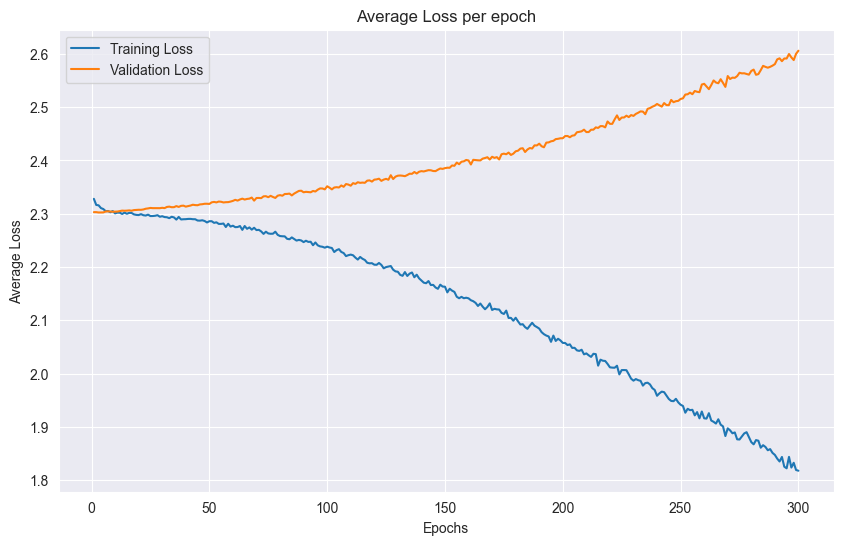

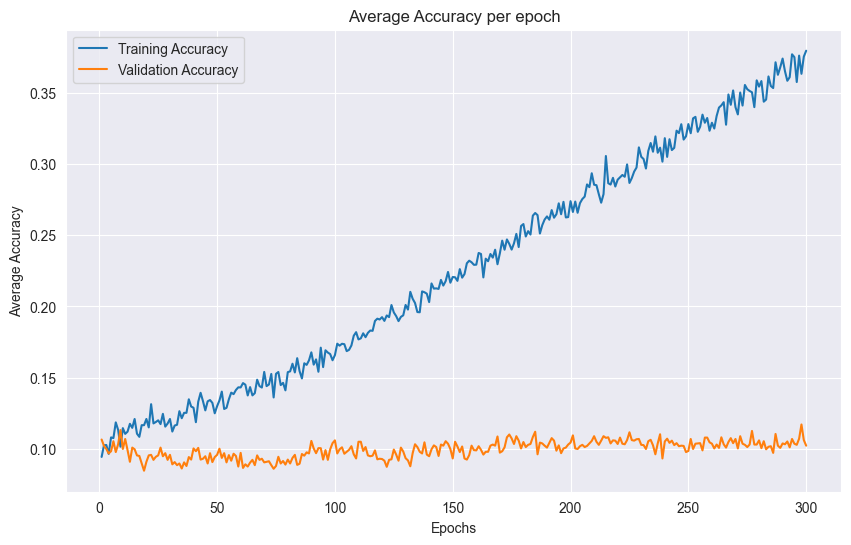

Overall Accuracy: 0.090


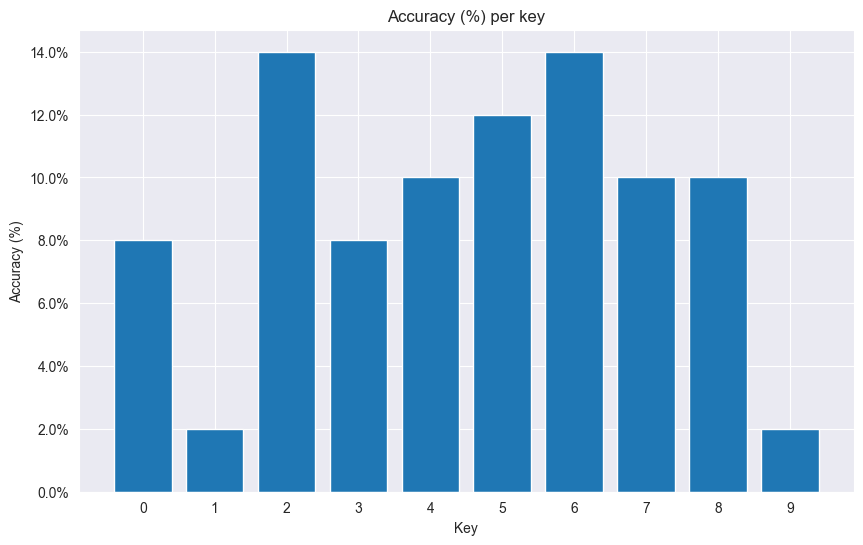

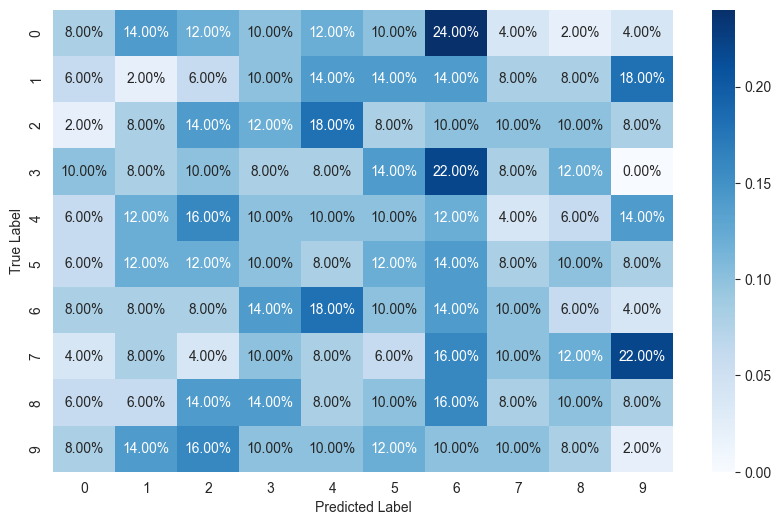

Accuracy for each key: 0: 8.0% 1: 2.0% 2: 14.0% 3: 8.0% 4: 10.0% 5: 12.0% 6: 14.0% 7: 10.0% 8: 10.0% 9: 2.0% 
              precision    recall  f1-score   support

           0       0.12      0.08      0.10        50
           1       0.02      0.02      0.02        50
           2       0.12      0.14      0.13        50
           3       0.07      0.08      0.08        50
           4       0.09      0.10      0.09        50
           5       0.11      0.12      0.12        50
           6       0.09      0.14      0.11        50
           7       0.12      0.10      0.11        50
           8       0.12      0.10      0.11        50
           9       0.02      0.02      0.02        50

    accuracy                           0.09       500
   macro avg       0.09      0.09      0.09       500
weighted avg       0.09      0.09      0.09       500

                    Model Parameters                    
Layer                    | Parameters
conv1d.weight            : 64 * 1 * 

In [17]:
def main():
    # setup parameters and load data
    batch_size = 64
    epochs = 300
    number_of_categories = 10
    
    X_train, X_val, X_test, y_train, y_val, y_test = importData()
    trainDataset = CSIDataset(X_train, y_train)
    valDataset = CSIDataset(X_val, y_val)
    
    trainLoader = DataLoader(trainDataset, shuffle=True, batch_size=batch_size)
    valLoader = DataLoader(valDataset, shuffle=True, batch_size=batch_size)

    model = CNN1D(number_of_categories)
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
    loss = nn.CrossEntropyLoss()
    
    if (os.path.isfile("model_final.pth")):
        model.load_state_dict(torch.load('model_final.pth'))
    else:
        train_loss_list, train_acc_list, eval_loss_list, eval_acc_list = train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss, (X_train.shape[0]//batch_size) + 1)
        # save the model
        torch.save(model.state_dict(), 'model_final.pth')
        plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs)
    
    # Simple check with test dataset
    model.eval()
    testDataset = CSIDataset(X_test, y_test)
    testLoader = DataLoader(testDataset, shuffle=True, batch_size=X_test.shape[0])
    test(model, testLoader, X_test.shape[0])
    
    print_model_parameters(model)
    
main()